# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Sat Dec 12 06:01:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8    12W / 151W |    332MiB /  8192MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [4]:
!dir "D:/Datasets/thesis_dr/aptos2019-blindness-detection/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr\aptos2019-blindness-detection

12/11/2020  12:40 AM    <DIR>          .
12/11/2020  12:40 AM    <DIR>          ..
03/20/2020  10:02 AM               124 desktop.ini
12/06/2020  07:57 AM         1,235,300 df_train_dhash.csv
12/06/2020  07:46 AM         1,235,300 df_train_duplicate.csv
12/10/2020  06:51 AM    <DIR>          models
12/18/2019  03:23 AM            28,938 sample_submission.csv
12/18/2019  03:23 AM            25,072 test.csv
10/10/2020  08:35 AM    <DIR>          test_images
12/18/2019  03:27 AM            54,948 train.csv
10/10/2020  08:35 AM    <DIR>          train_images
10/30/2020  07:20 PM    <DIR>          train_images_balance_mini
10/28/2020  11:42 PM    <DIR>          train_images_jpeg
12/11/2020  01:07 AM    <DIR>          train_images_rescaled_300
12/11/2020  01:07 AM    <DIR>          train_images_rescaled_300_crop
12/11/2020  01:07 AM    <DIR>          trai

In [5]:
# define our working directory
dir_base = 'D:/Datasets/thesis_dr/aptos2019-blindness-detection/'
dir_img = os.path.join(
    dir_base, 'train_images_rescaled_300')

if os.path.isdir(os.path.join(dir_base, 'models/kfold_rescale/')) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_rescale/'))

In [6]:
image_shape = (299, 299, 3)
batch_size = 32
lr_init = 1e-4
lr_tune = 2e-6
epoch_init = 50
epoch_tune = 50
# decay_init = lr_init / epoch_init
# decay_tune = lr_tune / epoch_tune
save_csv = 'log_training-20201212.csv'
save_EOE_train_head = 'EOE_classifier-20201212.h5'
save_best_train_head = 'best_classifier-20201212.h5'
save_EOE_train_body = 'EOE_fine_tune-20201212.h5'
save_best_train_body = 'best_fine_tune-20201212.h5'

# Prepare dataframe

- Split train & test
- Compute weight for each class

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

,id_code,diagnosis,is_exist,dhash,freq,keep
0,000c1434d8d7.png,2,True,4505549846649357848361897357201341356077337430...,1,yes
1,001639a390f0.png,4,True,2329637184878609198035515006640525134579216941...,1,yes
2,0024cdab0c1e.png,1,True,2423240825355712633243422248054645083667877231...,1,yes
3,002c21358ce6.png,0,True,6900833685078708622050523299339707984650415156...,1,yes
4,005b95c28852.png,0,True,1596672251484725956711788094558338750112176232...,1,yes
...,...,...,...,...,...,...
3657,ffa47f6a7bf4.png,2,True,1714415029888012417314661111083115996014360412...,1,yes
3658,ffc04fed30e6.png,0,True,1596672252599988637907833311359172559898032526...,1,yes
3659,ffcf7b45f213.png,2,True,2371174750225767638951270617106319090295289270...,1,yes
3660,ffd97f8cd5aa.png,0,True,4495615386714830418073151623371454397778002504...,1,yes


In [8]:
df.groupby('diagnosis')[['id_code']].count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [9]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3493,ffa47f6a7bf4.png,2
3494,ffc04fed30e6.png,0
3495,ffcf7b45f213.png,2
3496,ffd97f8cd5aa.png,0


In [10]:
df.groupby('diagnosis').count()

,id_code
diagnosis,
0,1796
1,338
2,921
3,173
4,270


In [11]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [12]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']
                             ], df.iloc[dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

,id_code
diagnosis,
0,1437
1,271
2,736
3,138
4,216


In [13]:
df_valid.groupby('diagnosis').count()

,id_code
diagnosis,
0,359
1,67
2,185
3,35
4,54


In [14]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [15]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [16]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

# Define Model

In [17]:
def create_model():
    conv_base = InceptionV3(
        include_top=False, weights='imagenet', input_shape=(image_shape))
    conv_base.trainable = False

    input_layer = keras.Input(shape=image_shape)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, seed=123)(x)
    x = layers.Dense(512, kernel_initializer=initializers.GlorotUniform(
        seed=123), kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5, seed=321)(x)
    x = layers.Dense(
        5, kernel_initializer=initializers.GlorotUniform(seed=321))(x)
    output_layer = layers.Activation('softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return conv_base, model

In [18]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()]

In [19]:
# define plot function
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='valid loss')
    plt.title('Training & Valid Loss')
    plt.legend()
    plt.show()


def plot_acc(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='valid acc')
    plt.title('Training & Valid Accuracy')
    plt.legend()
    plt.show()


def plot_precision(history):
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(1, len(precision) + 1)

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='valid precision')
    plt.title('Training & Valid Precision')
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(recall) + 1)

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='valid recall')
    plt.title('Training & Valid Recall')
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(1, len(auc) + 1)

    plt.plot(epochs, auc, label='training auc')
    plt.plot(epochs, val_auc, label='valid auc')
    plt.title('Training & Valid AUC')
    plt.legend()
    plt.show()

# Define Image Generator

In [20]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    data_format='channels_last')

test_datagen = image.ImageDataGenerator(
    data_format='channels_last')

In [21]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

## Check training dataset

In [22]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [23]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [24]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [25]:
fname = train_generator.filenames[image_idx]
fname

'ea5c42a78979.png'

In [26]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
3233,ea5c42a78979.png,0


In [27]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

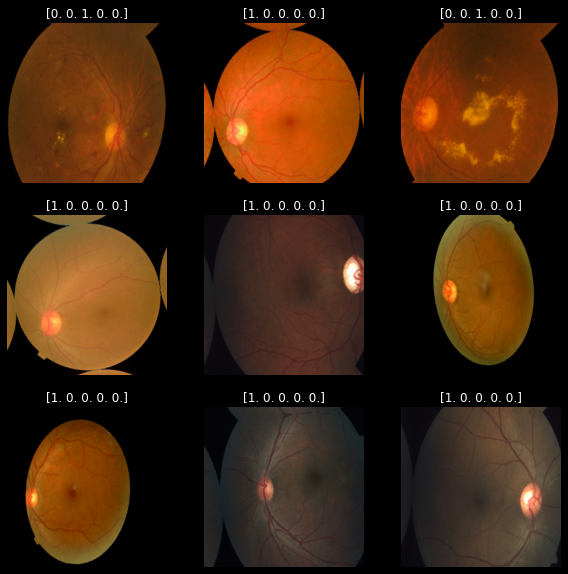

In [28]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Check validation dataset

In [29]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [30]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

0

In [31]:
fname = valid_generator.filenames[image_idx]
fname

'a44345b27804.png'

In [32]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
2261,a44345b27804.png,0


In [33]:
valid_images_7, valid_labels_7 = valid_generator[7]
print(valid_images_7.shape)
print(valid_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

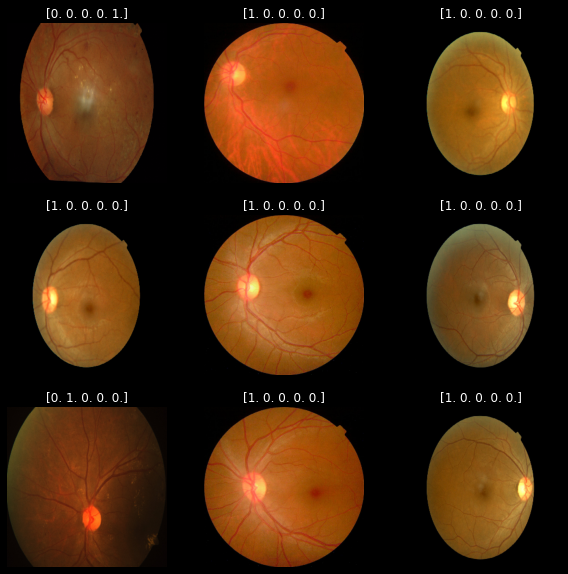

In [34]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis('off')

plt.show

# Fold 1

## Train classifier

In [35]:
fold = 1
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [36]:
df_valid.head(3)

,id_code,diagnosis
0,000c1434d8d7.png,2
5,0083ee8054ee.png,4
9,00cb6555d108.png,1


In [37]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))

In [38]:
conv_base, model = create_model()

In [39]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [40]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [41]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 2s - loss: 10.7878 - categorical_accuracy: 0.4776 - precision: 0.5558 - recall: 0.3944 - auc: 0.7638
Epoch 00001: val_loss improved from inf to 10.03518, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold1\best_classifier-20201212.h5
88/88 [==============================] - 260s 3s/step - loss: 10.7821 - categorical_accuracy: 0.4778 - precision: 0.5554 - recall: 0.3939 - auc: 0.7645 - val_loss: 10.0352 - val_categorical_accuracy: 0.6257 - val_precision: 0.9041 - val_recall: 0.3771 - val_auc: 0.8845
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0863 - categorical_accuracy: 0.5926 - precision: 0.6740 - recall: 0.5202 - auc: 0.8496
Epoch 00002: val_loss improved from 10.03518 to 9.59844, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.8883 - categorical_accuracy: 0.7440 - precision: 0.8105 - recall: 0.6743 - auc: 0.9458
Epoch 00028: val_loss improved from 4.07743 to 3.91829, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold1\best_classifier-20201212.h5
88/88 [==============================] - 137s 2s/step - loss: 3.8902 - categorical_accuracy: 0.7437 - precision: 0.8104 - recall: 0.6737 - auc: 0.9457 - val_loss: 3.9183 - val_categorical_accuracy: 0.7343 - val_precision: 0.8076 - val_recall: 0.6414 - val_auc: 0.9427
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.7894 - categorical_accuracy: 0.7437 - precision: 0.8034 - recall: 0.6721 - auc: 0.9460
Epoch 00029: val_loss improved from 3.91829 to 3.81731, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold1\best_classifier-20201212.h5
88/88 [==============================] - 138s 2s/step - lo

88/88 [==============================] - 139s 2s/step - loss: 2.5972 - categorical_accuracy: 0.7541 - precision: 0.8181 - recall: 0.6862 - auc: 0.9517 - val_loss: 2.7205 - val_categorical_accuracy: 0.7629 - val_precision: 0.8339 - val_recall: 0.6957 - val_auc: 0.9507
Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.5587 - categorical_accuracy: 0.7570 - precision: 0.8177 - recall: 0.6876 - auc: 0.9523
Epoch 00042: val_loss improved from 2.72053 to 2.65531, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold1\best_classifier-20201212.h5
88/88 [==============================] - 139s 2s/step - loss: 2.5604 - categorical_accuracy: 0.7566 - precision: 0.8177 - recall: 0.6876 - auc: 0.9518 - val_loss: 2.6553 - val_categorical_accuracy: 0.7429 - val_precision: 0.8269 - val_recall: 0.6757 - val_auc: 0.9506
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.4595 - categorical_accuracy: 0.7686 - precision: 0.8289 

In [42]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

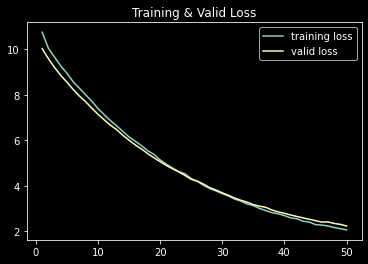

In [43]:
plot_loss(history)

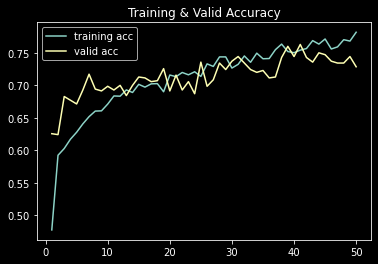

In [44]:
plot_acc(history)

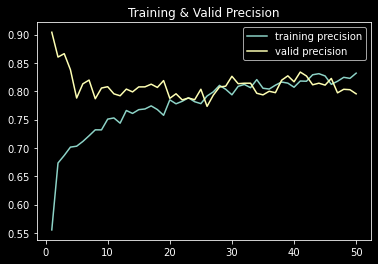

In [45]:
plot_precision(history)

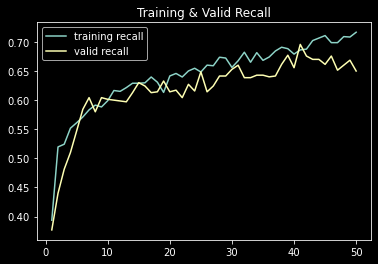

In [46]:
plot_recall(history)

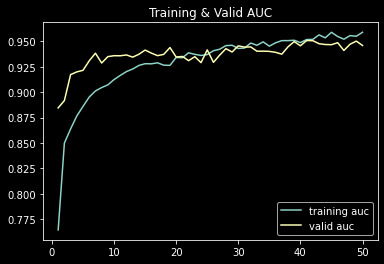

In [47]:
plot_auc(history)

### Evaluate model

In [48]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 629ms/step - loss: 1.9868 - categorical_accuracy: 0.7286 - precision: 0.7955 - recall: 0.6500 - auc: 0.9458


[1.9867504943500867, 0.7285714, 0.79545456, 0.65, 0.9458388]

In [49]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [50]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 573ms/step


In [51]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.95      0.96       359
         mild       0.51      0.64      0.57        67
     moderate       0.75      0.44      0.56       185
       severe       0.32      0.63      0.42        35
proliferative       0.26      0.41      0.32        54

     accuracy                           0.73       700
    macro avg       0.56      0.61      0.56       700
 weighted avg       0.78      0.73      0.74       700



In [52]:
confusion_matrix(y_true, y_pred)

array([[341,  13,   2,   0,   3],
       [  7,  43,  12,   1,   4],
       [  2,  24,  82,  30,  47],
       [  0,   1,   3,  22,   9],
       [  1,   4,  11,  16,  22]], dtype=int64)

## Fine Tune

In [53]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [55]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [56]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0065 - categorical_accuracy: 0.7874 - precision: 0.8374 - recall: 0.7260 - auc: 0.9609
Epoch 00001: val_loss improved from inf to 2.23401, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold1\best_fine_tune-20201212.h5
88/88 [==============================] - 152s 2s/step - loss: 2.0085 - categorical_accuracy: 0.7863 - precision: 0.8364 - recall: 0.7252 - auc: 0.9607 - val_loss: 2.2340 - val_categorical_accuracy: 0.7329 - val_precision: 0.8003 - val_recall: 0.6643 - val_auc: 0.9476
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0185 - categorical_accuracy: 0.7798 - precision: 0.8322 - recall: 0.7223 - auc: 0.9597
Epoch 00002: val_loss improved from 2.23401 to 2.22908, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold1\b

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 1.9466 - categorical_accuracy: 0.7936 - precision: 0.8455 - recall: 0.7419 - auc: 0.9648
Epoch 00015: val_loss improved from 2.20218 to 2.19889, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold1\best_fine_tune-20201212.h5
88/88 [==============================] - 139s 2s/step - loss: 1.9484 - categorical_accuracy: 0.7931 - precision: 0.8452 - recall: 0.7412 - auc: 0.9647 - val_loss: 2.1989 - val_categorical_accuracy: 0.7500 - val_precision: 0.7986 - val_recall: 0.6743 - val_auc: 0.9479
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 1.9474 - categorical_accuracy: 0.7950 - precision: 0.8460 - recall: 0.7386 - auc: 0.9642
Epoch 00016: val_loss improved from 2.19889 to 2.19886, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold1\best_fine_tune-20201212.h5
88/88 [==============================] - 139s 2s/step - loss

Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 1.8593 - categorical_accuracy: 0.8174 - precision: 0.8677 - recall: 0.7661 - auc: 0.9713
Epoch 00030: val_loss did not improve from 2.18235
88/88 [==============================] - 135s 2s/step - loss: 1.8586 - categorical_accuracy: 0.8163 - precision: 0.8668 - recall: 0.7652 - auc: 0.9712 - val_loss: 2.1836 - val_categorical_accuracy: 0.7557 - val_precision: 0.8070 - val_recall: 0.6929 - val_auc: 0.9508
Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.8630 - categorical_accuracy: 0.8160 - precision: 0.8582 - recall: 0.7679 - auc: 0.9712
Epoch 00031: val_loss improved from 2.18235 to 2.17944, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold1\best_fine_tune-20201212.h5
88/88 [==============================] - 139s 2s/step - loss: 1.8622 - categorical_accuracy: 0.8159 - precision: 0.8582 - recall: 0.7680 - auc: 0.9710 - val_loss: 2.1794 - val_categorical

In [57]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

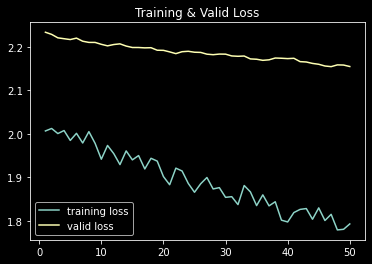

In [58]:
plot_loss(history)

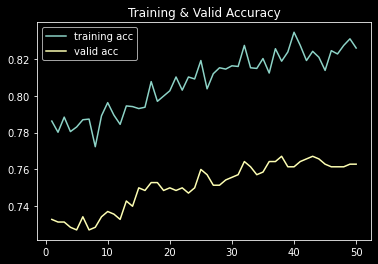

In [59]:
plot_acc(history)

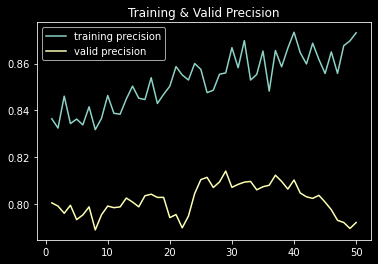

In [60]:
plot_precision(history)

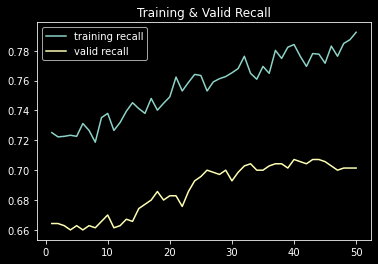

In [61]:
plot_recall(history)

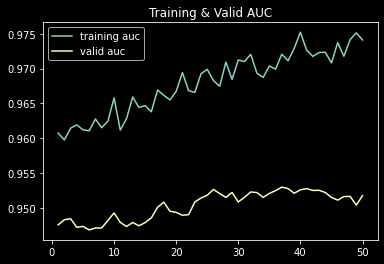

In [62]:
plot_auc(history)

### Evaluate model

In [63]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 636ms/step - loss: 1.8886 - categorical_accuracy: 0.7629 - precision: 0.7919 - recall: 0.7014 - auc: 0.9517


[1.8885935382409529, 0.76285714, 0.7919355, 0.7014286, 0.9517414]

In [64]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [65]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 626ms/step


In [66]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.98      0.94      0.96       359
         mild       0.47      0.75      0.58        67
     moderate       0.79      0.50      0.62       185
       severe       0.40      0.71      0.52        35
proliferative       0.41      0.54      0.46        54

     accuracy                           0.76       700
    macro avg       0.61      0.69      0.63       700
 weighted avg       0.81      0.76      0.77       700



In [67]:
confusion_matrix(y_true, y_pred)

array([[337,  21,   1,   0,   0],
       [  5,  50,  11,   0,   1],
       [  1,  29,  93,  26,  36],
       [  0,   2,   3,  25,   5],
       [  1,   4,   9,  11,  29]], dtype=int64)

# Fold 2

## Train classifier

In [68]:
del(model)

In [69]:
fold = 2
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [70]:
df_valid.head(3)

,id_code,diagnosis
1,001639a390f0.png,4
3,002c21358ce6.png,0
11,00e4ddff966a.png,2


In [71]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))

In [72]:
conv_base, model = create_model()

In [73]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [74]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [75]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7595 - categorical_accuracy: 0.4756 - precision: 0.5675 - recall: 0.3897 - auc: 0.7647
Epoch 00001: val_loss improved from inf to 10.13180, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold2\best_classifier-20201212.h5
88/88 [==============================] - 152s 2s/step - loss: 10.7490 - categorical_accuracy: 0.4761 - precision: 0.5673 - recall: 0.3903 - auc: 0.7651 - val_loss: 10.1318 - val_categorical_accuracy: 0.6643 - val_precision: 0.8947 - val_recall: 0.4371 - val_auc: 0.9000
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0540 - categorical_accuracy: 0.5824 - precision: 0.6654 - recall: 0.5040 - auc: 0.8482
Epoch 00002: val_loss improved from 10.13180 to 9.65794, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.7826 - categorical_accuracy: 0.7303 - precision: 0.7901 - recall: 0.6573 - auc: 0.9422
Epoch 00028: val_loss improved from 4.00003 to 3.87201, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold2\best_classifier-20201212.h5
88/88 [==============================] - 138s 2s/step - loss: 3.7828 - categorical_accuracy: 0.7302 - precision: 0.7893 - recall: 0.6562 - auc: 0.9421 - val_loss: 3.8720 - val_categorical_accuracy: 0.7614 - val_precision: 0.8290 - val_recall: 0.6857 - val_auc: 0.9515
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.6443 - categorical_accuracy: 0.7368 - precision: 0.7959 - recall: 0.6725 - auc: 0.9451
Epoch 00029: val_loss improved from 3.87201 to 3.76719, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold2\best_classifier-20201212.h5
88/88 [==============================] - 138s 2s/step - lo

88/88 [==============================] - 138s 2s/step - loss: 2.5021 - categorical_accuracy: 0.7723 - precision: 0.8247 - recall: 0.7030 - auc: 0.9554 - val_loss: 2.7412 - val_categorical_accuracy: 0.7643 - val_precision: 0.8142 - val_recall: 0.6886 - val_auc: 0.9519
Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.4337 - categorical_accuracy: 0.7697 - precision: 0.8258 - recall: 0.6992 - auc: 0.9538
Epoch 00042: val_loss improved from 2.74125 to 2.64724, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold2\best_classifier-20201212.h5
88/88 [==============================] - 139s 2s/step - loss: 2.4308 - categorical_accuracy: 0.7702 - precision: 0.8272 - recall: 0.6998 - auc: 0.9540 - val_loss: 2.6472 - val_categorical_accuracy: 0.7700 - val_precision: 0.8242 - val_recall: 0.6900 - val_auc: 0.9514
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.3508 - categorical_accuracy: 0.7762 - precision: 0.8340 

In [76]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

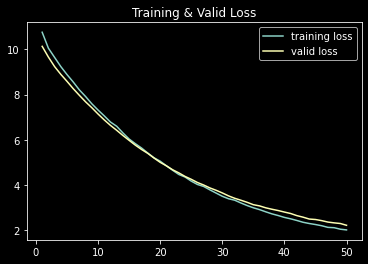

In [77]:
plot_loss(history)

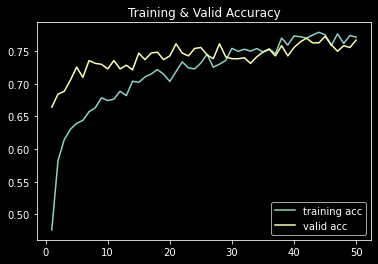

In [78]:
plot_acc(history)

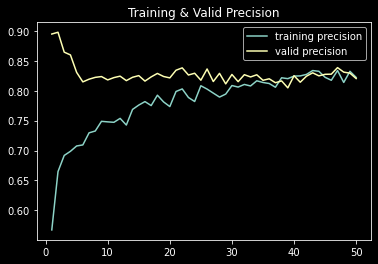

In [79]:
plot_precision(history)

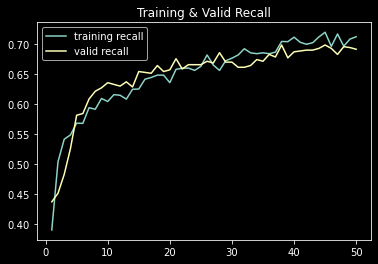

In [80]:
plot_recall(history)

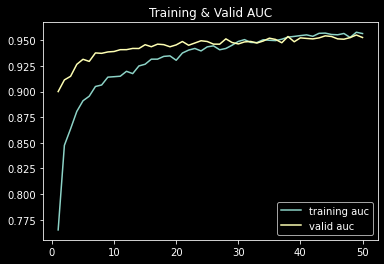

In [81]:
plot_auc(history)

### Evaluate model

In [82]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 633ms/step - loss: 1.8803 - categorical_accuracy: 0.7671 - precision: 0.8203 - recall: 0.6914 - auc: 0.9528


[1.8802935589443555, 0.76714283, 0.82033896, 0.69142854, 0.95280915]

In [83]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [84]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 578ms/step


In [85]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.98      0.98       359
         mild       0.48      0.60      0.54        68
     moderate       0.78      0.56      0.65       184
       severe       0.28      0.54      0.37        35
proliferative       0.43      0.43      0.43        54

     accuracy                           0.77       700
    macro avg       0.59      0.62      0.59       700
 weighted avg       0.80      0.77      0.78       700



In [86]:
confusion_matrix(y_true, y_pred)

array([[351,   3,   4,   1,   0],
       [  4,  41,  11,   5,   7],
       [  4,  33, 103,  28,  16],
       [  0,   2,   6,  19,   8],
       [  1,   6,   8,  16,  23]], dtype=int64)

## Fine Tune

In [87]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [88]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [89]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [90]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9383 - categorical_accuracy: 0.7701 - precision: 0.8302 - recall: 0.7108 - auc: 0.9582
Epoch 00001: val_loss improved from inf to 2.22611, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold2\best_fine_tune-20201212.h5
88/88 [==============================] - 154s 2s/step - loss: 1.9411 - categorical_accuracy: 0.7706 - precision: 0.8300 - recall: 0.7102 - auc: 0.9580 - val_loss: 2.2261 - val_categorical_accuracy: 0.7671 - val_precision: 0.8226 - val_recall: 0.6957 - val_auc: 0.9542
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9266 - categorical_accuracy: 0.7878 - precision: 0.8426 - recall: 0.7256 - auc: 0.9608
Epoch 00002: val_loss improved from 2.22611 to 2.22416, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold2\b

Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.8360 - categorical_accuracy: 0.8051 - precision: 0.8550 - recall: 0.7523 - auc: 0.9681
Epoch 00017: val_loss did not improve from 2.21407
88/88 [==============================] - 136s 2s/step - loss: 1.8368 - categorical_accuracy: 0.8049 - precision: 0.8557 - recall: 0.7527 - auc: 0.9682 - val_loss: 2.2223 - val_categorical_accuracy: 0.7829 - val_precision: 0.8364 - val_recall: 0.7229 - val_auc: 0.9577
Epoch 18/50
87/88 [============================>.] - ETA: 1s - loss: 1.8403 - categorical_accuracy: 0.8069 - precision: 0.8523 - recall: 0.7552 - auc: 0.9681
Epoch 00018: val_loss did not improve from 2.21407
88/88 [==============================] - 136s 2s/step - loss: 1.8429 - categorical_accuracy: 0.8056 - precision: 0.8505 - recall: 0.7545 - auc: 0.9677 - val_loss: 2.2275 - val_categorical_accuracy: 0.7886 - val_precision: 0.8405 - val_recall: 0.7300 - val_auc: 0.9582
Epoch 19/50
87/88 [===========================

In [91]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

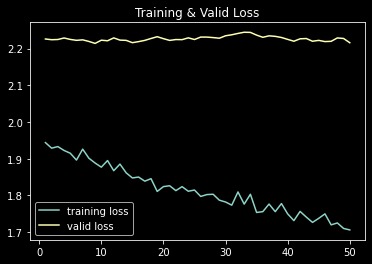

In [92]:
plot_loss(history)

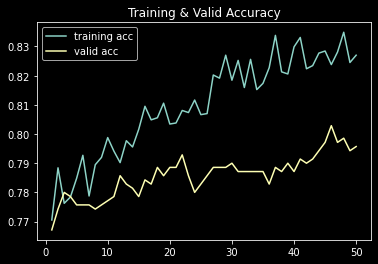

In [93]:
plot_acc(history)

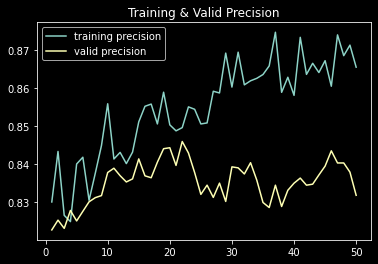

In [94]:
plot_precision(history)

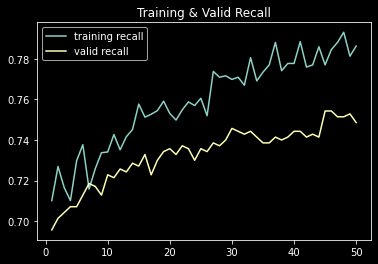

In [95]:
plot_recall(history)

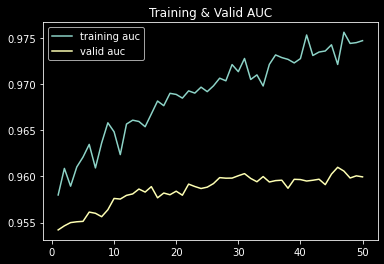

In [96]:
plot_auc(history)

### Evaluate model

In [97]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 638ms/step - loss: 1.7732 - categorical_accuracy: 0.7957 - precision: 0.8317 - recall: 0.7486 - auc: 0.9600


[1.7731951962817798, 0.79571426, 0.83174604, 0.74857146, 0.9599545]

In [98]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [99]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 579ms/step


In [100]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.98      0.98      0.98       359
         mild       0.57      0.63      0.60        68
     moderate       0.75      0.67      0.70       184
       severe       0.29      0.40      0.33        35
proliferative       0.49      0.46      0.48        54

     accuracy                           0.80       700
    macro avg       0.61      0.63      0.62       700
 weighted avg       0.81      0.80      0.80       700



In [101]:
confusion_matrix(y_true, y_pred)

array([[352,   3,   4,   0,   0],
       [  3,  43,  16,   3,   3],
       [  4,  22, 123,  22,  13],
       [  0,   2,   9,  14,  10],
       [  1,   5,  13,  10,  25]], dtype=int64)

# Fold 3

## Train classifier

In [102]:
del(model)

In [103]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [104]:
df_valid.head(3)

,id_code,diagnosis
2,0024cdab0c1e.png,1
12,00f6c1be5a33.png,0
18,0151781fe50b.png,0


In [105]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))

In [106]:
conv_base, model = create_model()

In [107]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [108]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [109]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7043 - categorical_accuracy: 0.5014 - precision: 0.5862 - recall: 0.4056 - auc: 0.7743
Epoch 00001: val_loss improved from inf to 10.13720, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold3\best_classifier-20201212.h5
88/88 [==============================] - 153s 2s/step - loss: 10.6987 - categorical_accuracy: 0.5025 - precision: 0.5867 - recall: 0.4064 - auc: 0.7745 - val_loss: 10.1372 - val_categorical_accuracy: 0.6700 - val_precision: 0.8822 - val_recall: 0.4600 - val_auc: 0.8965
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0085 - categorical_accuracy: 0.5893 - precision: 0.6698 - recall: 0.5119 - auc: 0.8533
Epoch 00002: val_loss improved from 10.13720 to 9.65282, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.7718 - categorical_accuracy: 0.7401 - precision: 0.8068 - recall: 0.6750 - auc: 0.9463
Epoch 00028: val_loss improved from 4.07692 to 3.98226, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold3\best_classifier-20201212.h5
88/88 [==============================] - 138s 2s/step - loss: 3.7718 - categorical_accuracy: 0.7405 - precision: 0.8073 - recall: 0.6755 - auc: 0.9464 - val_loss: 3.9823 - val_categorical_accuracy: 0.7229 - val_precision: 0.8067 - val_recall: 0.6557 - val_auc: 0.9369
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.6213 - categorical_accuracy: 0.7491 - precision: 0.8074 - recall: 0.6790 - auc: 0.9480
Epoch 00029: val_loss improved from 3.98226 to 3.85451, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold3\best_classifier-20201212.h5
88/88 [==============================] - 138s 2s/step - lo

88/88 [==============================] - 138s 2s/step - loss: 2.4949 - categorical_accuracy: 0.7670 - precision: 0.8209 - recall: 0.7059 - auc: 0.9552 - val_loss: 2.8327 - val_categorical_accuracy: 0.7300 - val_precision: 0.8058 - val_recall: 0.6700 - val_auc: 0.9451
Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.4009 - categorical_accuracy: 0.7889 - precision: 0.8373 - recall: 0.7184 - auc: 0.9597
Epoch 00042: val_loss improved from 2.83274 to 2.77788, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold3\best_classifier-20201212.h5
88/88 [==============================] - 139s 2s/step - loss: 2.3987 - categorical_accuracy: 0.7895 - precision: 0.8384 - recall: 0.7194 - auc: 0.9600 - val_loss: 2.7779 - val_categorical_accuracy: 0.7371 - val_precision: 0.8031 - val_recall: 0.6700 - val_auc: 0.9420
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.3616 - categorical_accuracy: 0.7762 - precision: 0.8308 

In [110]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

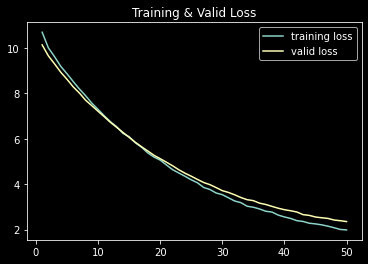

In [111]:
plot_loss(history)

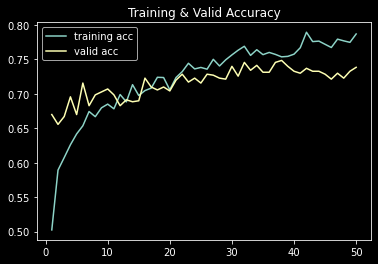

In [112]:
plot_acc(history)

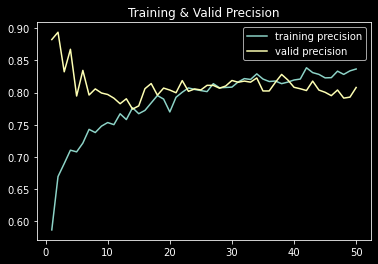

In [113]:
plot_precision(history)

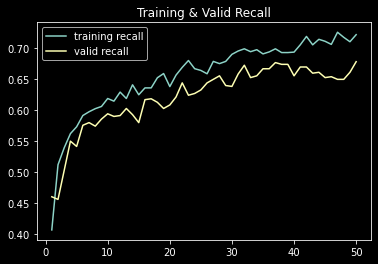

In [114]:
plot_recall(history)

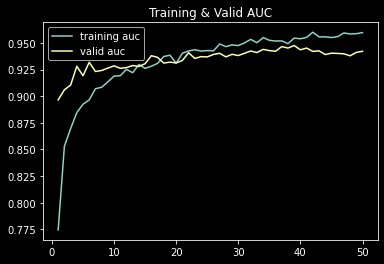

In [115]:
plot_auc(history)

### Evaluate model

In [116]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 633ms/step - loss: 1.9497 - categorical_accuracy: 0.7386 - precision: 0.8078 - recall: 0.6786 - auc: 0.9421


[1.949747296896848, 0.7385714, 0.8078231, 0.6785714, 0.94211227]

In [117]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [118]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 583ms/step


In [119]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.95      0.95      0.95       359
         mild       0.44      0.53      0.48        68
     moderate       0.64      0.56      0.60       184
       severe       0.31      0.49      0.38        35
proliferative       0.45      0.37      0.41        54

     accuracy                           0.74       700
    macro avg       0.56      0.58      0.56       700
 weighted avg       0.75      0.74      0.74       700



In [120]:
confusion_matrix(y_true, y_pred)

array([[341,   8,  10,   0,   0],
       [  7,  36,  22,   1,   2],
       [  8,  28, 103,  30,  15],
       [  0,   2,   9,  17,   7],
       [  2,   7,  18,   7,  20]], dtype=int64)

## Fine Tune

In [121]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [122]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [123]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [124]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9427 - categorical_accuracy: 0.7701 - precision: 0.8194 - recall: 0.7086 - auc: 0.9584
Epoch 00001: val_loss improved from inf to 2.35481, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold3\best_fine_tune-20201212.h5
88/88 [==============================] - 156s 2s/step - loss: 1.9413 - categorical_accuracy: 0.7698 - precision: 0.8186 - recall: 0.7080 - auc: 0.9584 - val_loss: 2.3548 - val_categorical_accuracy: 0.7357 - val_precision: 0.8051 - val_recall: 0.6786 - val_auc: 0.9430
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9351 - categorical_accuracy: 0.7903 - precision: 0.8341 - recall: 0.7343 - auc: 0.9630
Epoch 00002: val_loss did not improve from 2.35481
88/88 [==============================] - 136s 2s/step - loss: 1.9353 - categorical_accuracy: 0.7891 -

88/88 [==============================] - 140s 2s/step - loss: 1.8524 - categorical_accuracy: 0.8045 - precision: 0.8496 - recall: 0.7530 - auc: 0.9677 - val_loss: 2.3275 - val_categorical_accuracy: 0.7471 - val_precision: 0.7957 - val_recall: 0.6900 - val_auc: 0.9457
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.8324 - categorical_accuracy: 0.8127 - precision: 0.8577 - recall: 0.7668 - auc: 0.9694
Epoch 00017: val_loss improved from 2.32748 to 2.32688, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold3\best_fine_tune-20201212.h5
88/88 [==============================] - 140s 2s/step - loss: 1.8327 - categorical_accuracy: 0.8131 - precision: 0.8580 - recall: 0.7666 - auc: 0.9695 - val_loss: 2.3269 - val_categorical_accuracy: 0.7429 - val_precision: 0.7950 - val_recall: 0.6871 - val_auc: 0.9455
Epoch 18/50
87/88 [============================>.] - ETA: 1s - loss: 1.8393 - categorical_accuracy: 0.8113 - precision: 0.8593 -

88/88 [==============================] - 143s 2s/step - loss: 1.7086 - categorical_accuracy: 0.8449 - precision: 0.8812 - recall: 0.8034 - auc: 0.9763 - val_loss: 2.3038 - val_categorical_accuracy: 0.7557 - val_precision: 0.7968 - val_recall: 0.7171 - val_auc: 0.9495
Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.7205 - categorical_accuracy: 0.8341 - precision: 0.8780 - recall: 0.7986 - auc: 0.9759
Epoch 00049: val_loss did not improve from 2.30383
88/88 [==============================] - 174s 2s/step - loss: 1.7234 - categorical_accuracy: 0.8327 - precision: 0.8770 - recall: 0.7974 - auc: 0.9754 - val_loss: 2.3095 - val_categorical_accuracy: 0.7614 - val_precision: 0.7943 - val_recall: 0.7171 - val_auc: 0.9500
Epoch 50/50
87/88 [============================>.] - ETA: 1s - loss: 1.7138 - categorical_accuracy: 0.8330 - precision: 0.8718 - recall: 0.7943 - auc: 0.9760
Epoch 00050: val_loss did not improve from 2.30383
88/88 [==============================] - 143s 

In [125]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

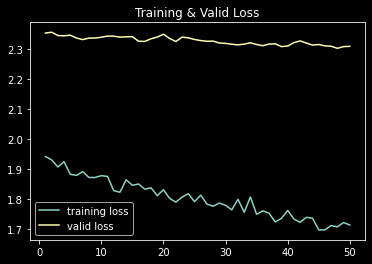

In [126]:
plot_loss(history)

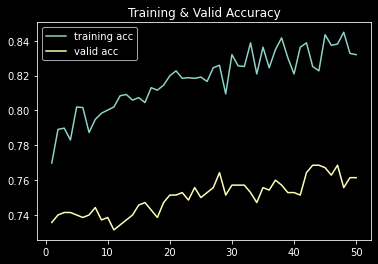

In [127]:
plot_acc(history)

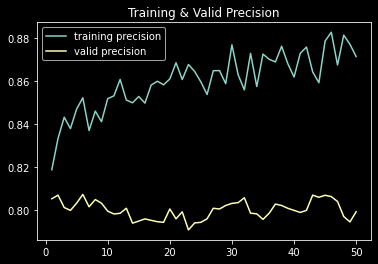

In [128]:
plot_precision(history)

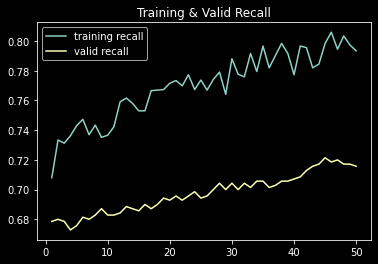

In [129]:
plot_recall(history)

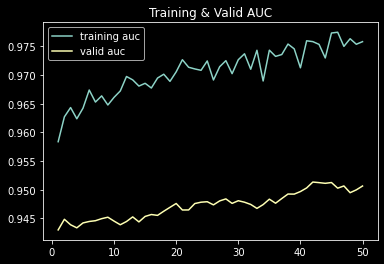

In [130]:
plot_auc(history)

### Evaluate model

In [131]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 656ms/step - loss: 1.8485 - categorical_accuracy: 0.7614 - precision: 0.7990 - recall: 0.7157 - auc: 0.9506


[1.8485355973243713, 0.7614286, 0.79904306, 0.7157143, 0.95063823]

In [132]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [133]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 591ms/step


In [134]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.95      0.96      0.96       359
         mild       0.47      0.47      0.47        68
     moderate       0.67      0.65      0.66       184
       severe       0.38      0.43      0.41        35
proliferative       0.40      0.39      0.39        54

     accuracy                           0.76       700
    macro avg       0.58      0.58      0.58       700
 weighted avg       0.76      0.76      0.76       700



In [135]:
confusion_matrix(y_true, y_pred)

array([[345,   7,   7,   0,   0],
       [  8,  32,  24,   2,   2],
       [  7,  22, 120,  15,  20],
       [  0,   1,   9,  15,  10],
       [  2,   6,  18,   7,  21]], dtype=int64)

# Fold 4

## Train classifier

In [136]:
del(model)

In [137]:
fold = 4
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [138]:
df_valid.head(3)

,id_code,diagnosis
4,005b95c28852.png,0
10,00cc2b75cddd.png,0
13,0104b032c141.png,3


In [139]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))

In [140]:
conv_base, model = create_model()

In [141]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [142]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [143]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.6789 - categorical_accuracy: 0.4944 - precision: 0.5741 - recall: 0.4102 - auc: 0.7804
Epoch 00001: val_loss improved from inf to 10.11383, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold4\best_classifier-20201212.h5
88/88 [==============================] - 177s 2s/step - loss: 10.6703 - categorical_accuracy: 0.4966 - precision: 0.5763 - recall: 0.4116 - auc: 0.7816 - val_loss: 10.1138 - val_categorical_accuracy: 0.6237 - val_precision: 0.8636 - val_recall: 0.4077 - val_auc: 0.8740
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0498 - categorical_accuracy: 0.5898 - precision: 0.6594 - recall: 0.5136 - auc: 0.8511
Epoch 00002: val_loss improved from 10.11383 to 9.55533, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.7705 - categorical_accuracy: 0.7365 - precision: 0.8023 - recall: 0.6628 - auc: 0.9446
Epoch 00028: val_loss improved from 3.89710 to 3.77640, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold4\best_classifier-20201212.h5
88/88 [==============================] - 142s 2s/step - loss: 3.7756 - categorical_accuracy: 0.7360 - precision: 0.8016 - recall: 0.6613 - auc: 0.9444 - val_loss: 3.7764 - val_categorical_accuracy: 0.7740 - val_precision: 0.8339 - val_recall: 0.6967 - val_auc: 0.9537
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.6363 - categorical_accuracy: 0.7488 - precision: 0.8036 - recall: 0.6773 - auc: 0.9477
Epoch 00029: val_loss improved from 3.77640 to 3.66982, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold4\best_classifier-20201212.h5
88/88 [==============================] - 142s 2s/step - lo

88/88 [==============================] - 140s 2s/step - loss: 2.5188 - categorical_accuracy: 0.7503 - precision: 0.8173 - recall: 0.6920 - auc: 0.9505 - val_loss: 2.6254 - val_categorical_accuracy: 0.7539 - val_precision: 0.8049 - val_recall: 0.7024 - val_auc: 0.9505
Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.4420 - categorical_accuracy: 0.7546 - precision: 0.8214 - recall: 0.6896 - auc: 0.9541
Epoch 00042: val_loss improved from 2.62541 to 2.53078, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold4\best_classifier-20201212.h5
88/88 [==============================] - 140s 2s/step - loss: 2.4421 - categorical_accuracy: 0.7535 - precision: 0.8207 - recall: 0.6885 - auc: 0.9536 - val_loss: 2.5308 - val_categorical_accuracy: 0.7625 - val_precision: 0.8259 - val_recall: 0.7124 - val_auc: 0.9531
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.4010 - categorical_accuracy: 0.7647 - precision: 0.8230 

In [144]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

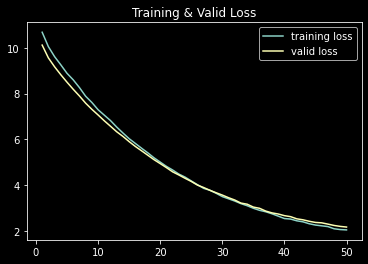

In [145]:
plot_loss(history)

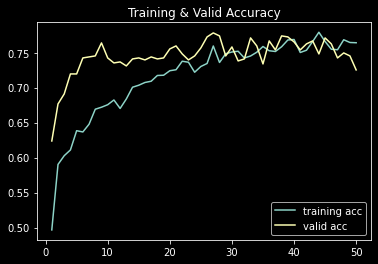

In [146]:
plot_acc(history)

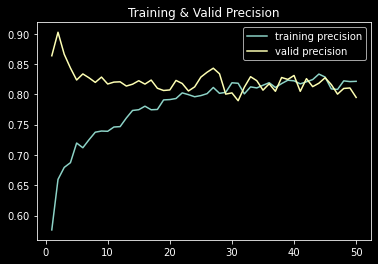

In [147]:
plot_precision(history)

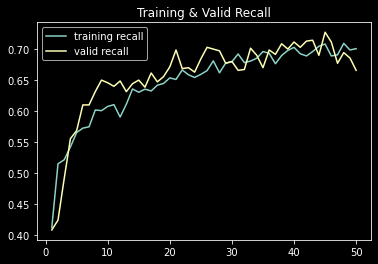

In [148]:
plot_recall(history)

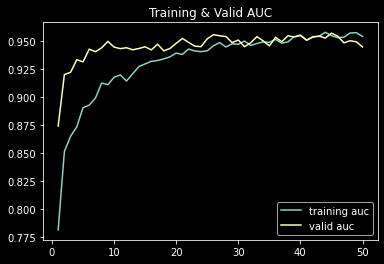

In [149]:
plot_auc(history)

### Evaluate model

In [150]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 651ms/step - loss: 1.9391 - categorical_accuracy: 0.7253 - precision: 0.7949 - recall: 0.6652 - auc: 0.9445


[1.939074781807986, 0.7253219, 0.7948718, 0.66523606, 0.94448125]

In [151]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [152]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 596ms/step


In [153]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.92      0.94       359
         mild       0.43      0.71      0.53        68
     moderate       0.77      0.45      0.56       184
       severe       0.30      0.76      0.43        34
proliferative       0.40      0.37      0.38        54

     accuracy                           0.73       699
    macro avg       0.57      0.64      0.57       699
 weighted avg       0.79      0.73      0.74       699



In [154]:
confusion_matrix(y_true, y_pred)

array([[331,  23,   0,   1,   4],
       [  5,  48,  11,   2,   2],
       [  6,  36,  82,  41,  19],
       [  0,   1,   2,  26,   5],
       [  0,   4,  12,  18,  20]], dtype=int64)

## Fine Tune

In [155]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [156]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [157]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [158]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9720 - categorical_accuracy: 0.7647 - precision: 0.8245 - recall: 0.7047 - auc: 0.9563
Epoch 00001: val_loss improved from inf to 2.16485, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold4\best_fine_tune-20201212.h5
88/88 [==============================] - 158s 2s/step - loss: 1.9748 - categorical_accuracy: 0.7638 - precision: 0.8225 - recall: 0.7038 - auc: 0.9561 - val_loss: 2.1649 - val_categorical_accuracy: 0.7425 - val_precision: 0.8020 - val_recall: 0.6838 - val_auc: 0.9489
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9234 - categorical_accuracy: 0.7889 - precision: 0.8495 - recall: 0.7300 - auc: 0.9623
Epoch 00002: val_loss improved from 2.16485 to 2.15982, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold4\b

Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.7975 - categorical_accuracy: 0.8146 - precision: 0.8579 - recall: 0.7615 - auc: 0.9709
Epoch 00031: val_loss did not improve from 2.12040
88/88 [==============================] - 139s 2s/step - loss: 1.7948 - categorical_accuracy: 0.8149 - precision: 0.8580 - recall: 0.7621 - auc: 0.9709 - val_loss: 2.1240 - val_categorical_accuracy: 0.7825 - val_precision: 0.8162 - val_recall: 0.7368 - val_auc: 0.9586
Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.7722 - categorical_accuracy: 0.8269 - precision: 0.8688 - recall: 0.7828 - auc: 0.9729
Epoch 00032: val_loss improved from 2.12040 to 2.11770, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold4\best_fine_tune-20201212.h5
88/88 [==============================] - 143s 2s/step - loss: 1.7746 - categorical_accuracy: 0.8267 - precision: 0.8687 - recall: 0.7824 - auc: 0.9728 - val_loss: 2.1177 - val_categorical

In [159]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

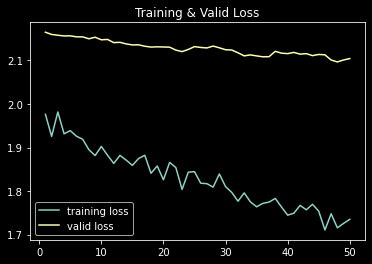

In [160]:
plot_loss(history)

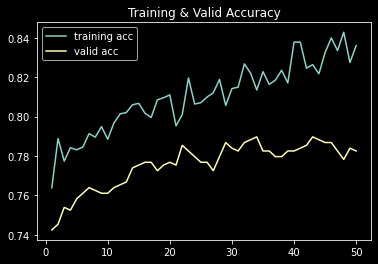

In [161]:
plot_acc(history)

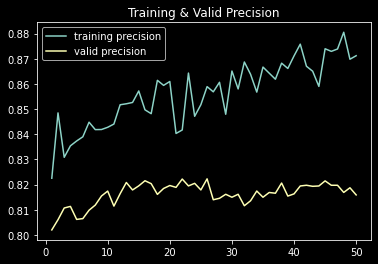

In [162]:
plot_precision(history)

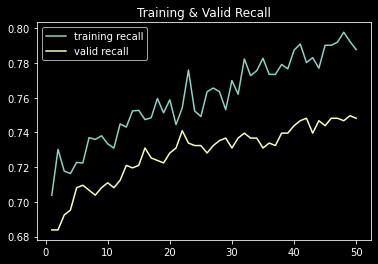

In [163]:
plot_recall(history)

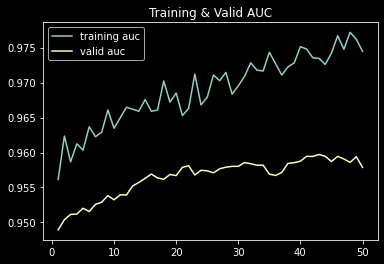

In [164]:
plot_auc(history)

### Evaluate model

In [165]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 15s 661ms/step - loss: 1.7903 - categorical_accuracy: 0.7825 - precision: 0.8159 - recall: 0.7482 - auc: 0.9579


[1.7903291149572893, 0.7825465, 0.81591266, 0.74821174, 0.9578682]

In [166]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [167]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 593ms/step


In [168]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.95      0.96       359
         mild       0.51      0.65      0.57        68
     moderate       0.73      0.65      0.68       184
       severe       0.42      0.65      0.51        34
proliferative       0.49      0.41      0.44        54

     accuracy                           0.78       699
    macro avg       0.62      0.66      0.63       699
 weighted avg       0.80      0.78      0.79       699



In [169]:
confusion_matrix(y_true, y_pred)

array([[340,  13,   5,   0,   1],
       [  5,  44,  16,   0,   3],
       [  6,  24, 119,  21,  14],
       [  0,   1,   6,  22,   5],
       [  0,   4,  18,  10,  22]], dtype=int64)

# Fold 5

## Train classifier

In [170]:
del(model)

In [171]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [172]:
df_valid.head(3)

,id_code,diagnosis
6,0097f532ac9f.png,0
7,00a8624548a9.png,2
8,00b74780d31d.png,2


In [173]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_rescale/fold'+str(fold))

In [174]:
conv_base, model = create_model()

In [175]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [176]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [177]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7101 - categorical_accuracy: 0.4890 - precision: 0.5689 - recall: 0.3954 - auc: 0.7712
Epoch 00001: val_loss improved from inf to 10.14839, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold5\best_classifier-20201212.h5
88/88 [==============================] - 186s 2s/step - loss: 10.7025 - categorical_accuracy: 0.4884 - precision: 0.5689 - recall: 0.3955 - auc: 0.7708 - val_loss: 10.1484 - val_categorical_accuracy: 0.6609 - val_precision: 0.8792 - val_recall: 0.4478 - val_auc: 0.8924
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0675 - categorical_accuracy: 0.5884 - precision: 0.6683 - recall: 0.5081 - auc: 0.8454
Epoch 00002: val_loss improved from 10.14839 to 9.66255, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.7066 - categorical_accuracy: 0.7474 - precision: 0.8072 - recall: 0.6704 - auc: 0.9470
Epoch 00028: val_loss improved from 4.05071 to 3.92774, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold5\best_classifier-20201212.h5
88/88 [==============================] - 142s 2s/step - loss: 3.7016 - categorical_accuracy: 0.7474 - precision: 0.8068 - recall: 0.6713 - auc: 0.9474 - val_loss: 3.9277 - val_categorical_accuracy: 0.7310 - val_precision: 0.8099 - val_recall: 0.6524 - val_auc: 0.9415
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.5841 - categorical_accuracy: 0.7409 - precision: 0.7986 - recall: 0.6805 - auc: 0.9480
Epoch 00029: val_loss improved from 3.92774 to 3.80220, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold5\best_classifier-20201212.h5
88/88 [==============================] - 142s 2s/step - lo

88/88 [==============================] - 140s 2s/step - loss: 2.4803 - categorical_accuracy: 0.7588 - precision: 0.8169 - recall: 0.7028 - auc: 0.9535 - val_loss: 2.7888 - val_categorical_accuracy: 0.7339 - val_precision: 0.8227 - val_recall: 0.6438 - val_auc: 0.9426
Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.4053 - categorical_accuracy: 0.7687 - precision: 0.8160 - recall: 0.7102 - auc: 0.9558
Epoch 00042: val_loss improved from 2.78876 to 2.74617, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold5\best_classifier-20201212.h5
88/88 [==============================] - 138s 2s/step - loss: 2.4019 - categorical_accuracy: 0.7685 - precision: 0.8158 - recall: 0.7106 - auc: 0.9557 - val_loss: 2.7462 - val_categorical_accuracy: 0.6996 - val_precision: 0.7812 - val_recall: 0.6180 - val_auc: 0.9347
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.3528 - categorical_accuracy: 0.7644 - precision: 0.8119 

In [178]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

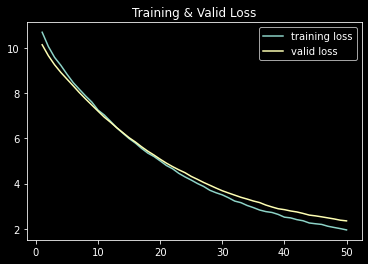

In [179]:
plot_loss(history)

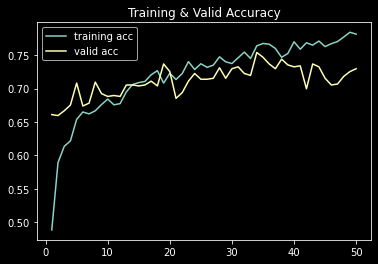

In [180]:
plot_acc(history)

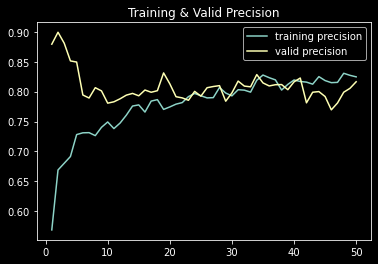

In [181]:
plot_precision(history)

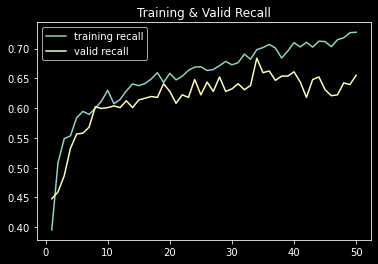

In [182]:
plot_recall(history)

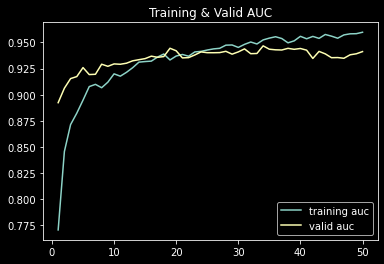

In [183]:
plot_auc(history)

### Evaluate model

In [184]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 646ms/step - loss: 1.9334 - categorical_accuracy: 0.7296 - precision: 0.8164 - recall: 0.6552 - auc: 0.9412


[1.9333690133961765, 0.7296137, 0.8163993, 0.65522176, 0.94122654]

In [185]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [186]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 594ms/step


In [187]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.94      0.95       360
         mild       0.46      0.57      0.51        67
     moderate       0.70      0.54      0.61       184
       severe       0.19      0.29      0.23        34
proliferative       0.32      0.43      0.37        54

     accuracy                           0.73       699
    macro avg       0.53      0.55      0.53       699
 weighted avg       0.76      0.73      0.74       699



In [188]:
confusion_matrix(y_true, y_pred)

array([[340,  12,   6,   0,   2],
       [  8,  38,  12,   2,   7],
       [  4,  24,  99,  30,  27],
       [  1,   0,  11,  10,  12],
       [  0,   8,  13,  10,  23]], dtype=int64)

## Fine Tune

In [189]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [190]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [191]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [192]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 1.9154 - categorical_accuracy: 0.7803 - precision: 0.8358 - recall: 0.7228 - auc: 0.9614
Epoch 00001: val_loss improved from inf to 2.34489, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold5\best_fine_tune-20201212.h5
88/88 [==============================] - 163s 2s/step - loss: 1.9123 - categorical_accuracy: 0.7814 - precision: 0.8368 - recall: 0.7238 - auc: 0.9618 - val_loss: 2.3449 - val_categorical_accuracy: 0.7425 - val_precision: 0.8224 - val_recall: 0.6624 - val_auc: 0.9425
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9028 - categorical_accuracy: 0.7824 - precision: 0.8298 - recall: 0.7261 - auc: 0.9618
Epoch 00002: val_loss improved from 2.34489 to 2.34014, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold5\b

88/88 [==============================] - 140s 2s/step - loss: 1.8263 - categorical_accuracy: 0.8042 - precision: 0.8417 - recall: 0.7449 - auc: 0.9670 - val_loss: 2.3119 - val_categorical_accuracy: 0.7468 - val_precision: 0.7993 - val_recall: 0.6667 - val_auc: 0.9431
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 1.8304 - categorical_accuracy: 0.8066 - precision: 0.8476 - recall: 0.7600 - auc: 0.9677
Epoch 00016: val_loss improved from 2.31194 to 2.31049, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_rescale/fold5\best_fine_tune-20201212.h5
88/88 [==============================] - 141s 2s/step - loss: 1.8287 - categorical_accuracy: 0.8060 - precision: 0.8471 - recall: 0.7599 - auc: 0.9676 - val_loss: 2.3105 - val_categorical_accuracy: 0.7439 - val_precision: 0.7993 - val_recall: 0.6667 - val_auc: 0.9431
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.8061 - categorical_accuracy: 0.8110 - precision: 0.8545 -

Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 1.6825 - categorical_accuracy: 0.8291 - precision: 0.8650 - recall: 0.7806 - auc: 0.9765
Epoch 00048: val_loss did not improve from 2.29416
88/88 [==============================] - 136s 2s/step - loss: 1.6806 - categorical_accuracy: 0.8289 - precision: 0.8646 - recall: 0.7803 - auc: 0.9765 - val_loss: 2.2985 - val_categorical_accuracy: 0.7654 - val_precision: 0.8068 - val_recall: 0.7110 - val_auc: 0.9484
Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.6745 - categorical_accuracy: 0.8385 - precision: 0.8698 - recall: 0.7994 - auc: 0.9761
Epoch 00049: val_loss did not improve from 2.29416
88/88 [==============================] - 136s 2s/step - loss: 1.6747 - categorical_accuracy: 0.8385 - precision: 0.8698 - recall: 0.7996 - auc: 0.9762 - val_loss: 2.2987 - val_categorical_accuracy: 0.7625 - val_precision: 0.8023 - val_recall: 0.7082 - val_auc: 0.9458
Epoch 50/50
87/88 [===========================

In [193]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

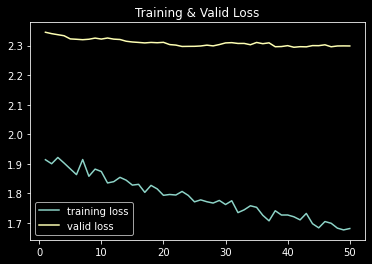

In [194]:
plot_loss(history)

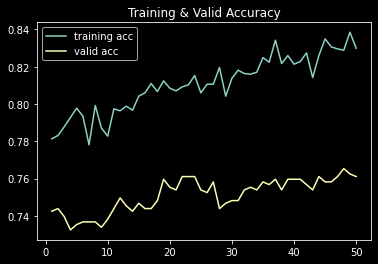

In [195]:
plot_acc(history)

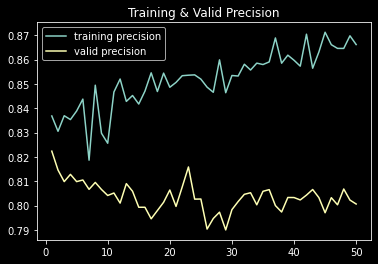

In [196]:
plot_precision(history)

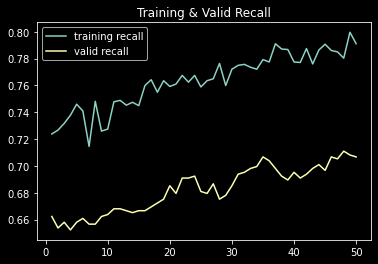

In [197]:
plot_recall(history)

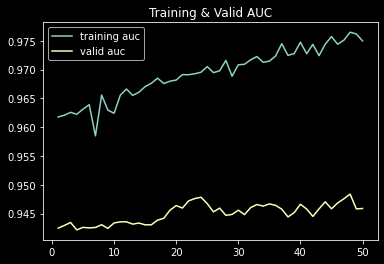

In [198]:
plot_auc(history)

### Evaluate model

In [199]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 654ms/step - loss: 1.8462 - categorical_accuracy: 0.7611 - precision: 0.8006 - recall: 0.7067 - auc: 0.9459


[1.8462319374084473, 0.76108724, 0.8006483, 0.70672387, 0.94589484]

In [200]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [201]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 589ms/step


In [202]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.93      0.95       360
         mild       0.48      0.61      0.54        67
     moderate       0.74      0.66      0.70       184
       severe       0.28      0.32      0.30        34
proliferative       0.36      0.44      0.40        54

     accuracy                           0.76       699
    macro avg       0.57      0.59      0.58       699
 weighted avg       0.78      0.76      0.77       699



In [203]:
confusion_matrix(y_true, y_pred)

array([[335,  17,   6,   0,   2],
       [  7,  41,  10,   3,   6],
       [  3,  19, 121,  18,  23],
       [  0,   0,  12,  11,  11],
       [  0,   8,  15,   7,  24]], dtype=int64)